# QR and AZTEC codes robustness comparisson

In [1]:
import numpy as np
import cv2 as cv
from PIL import Image, ImageOps, ImageFilter
import treepoem
from zxing import *

### 1) Generating Random Codes

Codes will be generated as random sequences of random length and duplicated for both QR and AZTEC code.

In [3]:
np.random.seed(0)

Let's generate 1k random codes.

In [49]:
import string
import random

In [50]:
NUM_SAMPLES = 1000
random_char_field = string.ascii_letters + string.digits + " "
keys = []

In [51]:
random.seed(0)
keys = ["".join(random.choices(random_char_field, k=random.randint(16, 64))) for _ in range(NUM_SAMPLES)] # GEN

In [57]:
for ind, key in enumerate(keys):
    qr = treepoem.generate_barcode(barcode_type="qrcode", data=key, options={"format":"full", "eclevel":"H"})
    qr.convert('1').save('qr/qr{}.png'.format(ind+1))
    aztec = treepoem.generate_barcode(barcode_type="azteccode", data=key, options={"format":"full"})
    aztec.convert('1').save('aztec/aztec{}.png'.format(ind+1))

In [58]:
import pickle

with open("keys.pickle", "wb") as f:
    pickle.dump(keys, f)

### 2) Defining check functions for each case of discrete pixel manipulation

In [63]:
import tqdm
import matplotlib.pyplot as plt
from matplotlib import image
%matplotlib inline

In [693]:
def pixel_value_xor(fname: str, imtype: str, change_rate=.01, verbose=False) -> bool:
    real_key = keys[int(fname.replace(imtype, "").replace(".png", "")) - 1]
    img = cv.imread(imtype + "/" + fname, cv.IMREAD_GRAYSCALE)
    
    if verbose:
        plt.imshow(img, cmap="gray")
        plt.show()
    
    _iter = int(img.shape[0] * img.shape[1] * change_rate)
    change_set = set()
    
    for _ in range(_iter):
        while 1:
            _temp = (np.random.randint(0, img.shape[0]), np.random.randint(0, img.shape[1]))
            if _temp not in change_set:
                change_set.add(_temp)
                break
    
    for x, y in change_set:
        img[x][y] ^=  np.random.randint(0, 256)
#         if img[x][y] > 255:
#             img[x][y] = 255

    if verbose:
        plt.imshow(img, cmap="gray")
        plt.show()
        
    Image.fromarray(img).save("buff.png")
    zx = BarCodeReader()
    bar = zx.decode("buff.png", try_harder=False)
#     print(bar)
    
    if bar is None:
        return False
    
    if real_key == bar.raw:
        return True
    else:
        return False

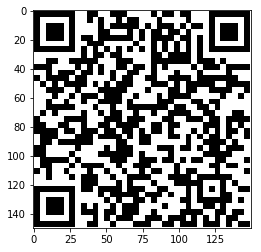

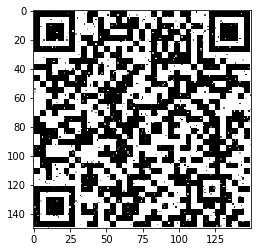

CPU times: user 751 ms, sys: 72.5 ms, total: 824 ms
Wall time: 1.15 s


False

In [694]:
%%time
pixel_value_xor("qr1.png", "qr", verbose=True, change_rate=.03)

In [310]:
def pixel_value_adding(fname: str, imtype: str, change_rate=.01, verbose=False) -> bool:
    real_key = keys[int(fname.replace(imtype, "").replace(".png", "")) - 1]
    img = cv.imread(imtype + "/" + fname, cv.IMREAD_GRAYSCALE)
    
    if verbose:
        plt.imshow(img, cmap="gray")
        plt.show()
    
    _iter = int(img.shape[0] * img.shape[1] * change_rate)
    change_set = set()
    
    for _ in range(_iter):
        while 1:
            _temp = (np.random.randint(0, img.shape[0]), np.random.randint(0, img.shape[1]))
            if _temp not in change_set:
                change_set.add(_temp)
                break
    
    for x, y in change_set:
        if img[x][y] == 255:
            continue
        img[x][y] +=  np.random.randint(0, 255-img[x][y])
#         if img[x][y] > 255:
#             img[x][y] = 255

    if verbose:
        plt.imshow(img, cmap="gray")
        plt.show()
        
    Image.fromarray(img).save("buff.png")
    zx = BarCodeReader()
    bar = zx.decode("buff.png")
#     print(bar)
    
    if bar is None:
        return False
    
    if real_key == bar.raw:
        return True
    else:
        return False

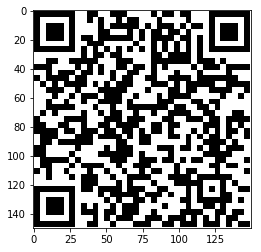

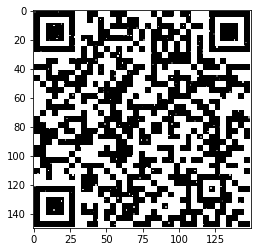

CPU times: user 1.33 s, sys: 610 ms, total: 1.94 s
Wall time: 2.66 s


True

In [435]:
%%time
pixel_value_adding("qr1.png", "qr", verbose=True, change_rate=.015)

In [262]:
def pixel_value_float_multiplying(fname: str, imtype: str, change_rate=.01, verbose=False) -> bool:
    real_key = keys[int(fname.replace(imtype, "").replace(".png", "")) - 1]
    img = cv.imread(imtype + "/" + fname, cv.IMREAD_GRAYSCALE)
    
    if verbose:
        plt.imshow(img, cmap="gray")
        plt.show()
    
    _iter = int(img.shape[0] * img.shape[1] * change_rate)
    change_set = set()
    
    for _ in range(_iter):
        while 1:
            _temp = (np.random.randint(0, img.shape[0]), np.random.randint(0, img.shape[1]))
            if _temp not in change_set:
                change_set.add(_temp)
                break
    
    for x, y in change_set:
        img[x][y] = int(img[x][y] / np.random.randint(1, 255))
    
    if verbose:
        plt.imshow(img, cmap="gray")
        plt.show()
        
    Image.fromarray(img).save("buff.png")
    zx = BarCodeReader()
    bar = zx.decode("buff.png")
#     print(bar)
    
    if bar is None:
        return False
    
    if real_key == bar.raw:
        return True
    else:
        return False

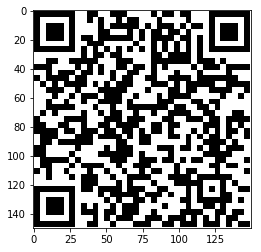

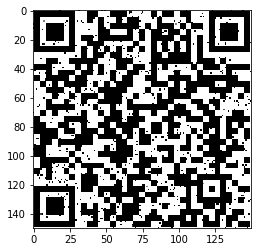

CPU times: user 732 ms, sys: 67.6 ms, total: 799 ms
Wall time: 1.02 s


False

In [455]:
%%time
pixel_value_float_multiplying("qr1.png", "qr", verbose=True, change_rate=.04)

In [226]:
def color_inverse(fname: str, imtype: str, change_rate=.01, verbose=False) -> bool:
    real_key = keys[int(fname.replace(imtype, "").replace(".png", "")) - 1]
    img = cv.imread(imtype + "/" + fname, cv.IMREAD_GRAYSCALE)
    
    if verbose:
        plt.imshow(img, cmap="gray")
        plt.show()
    
    _iter = int(img.shape[0] * img.shape[1] * change_rate)
    change_set = set()
    
    for _ in range(_iter):
        while 1:
            _temp = (np.random.randint(0, img.shape[0]), np.random.randint(0, img.shape[1]))
            if _temp not in change_set:
                change_set.add(_temp)
                break
    
    for x, y in change_set:
        if img[x][y] == 0:
            img[x][y] = 255
        else:
            img[x][y] = 0
    
    if verbose:
        plt.imshow(img, cmap="gray")
        plt.show()
        
    Image.fromarray(img).save("buff.png")
    zx = BarCodeReader()
    bar = zx.decode("buff.png")
    
    if bar is None:
        return False
    
    if real_key == bar.raw:
        return True
    else:
        return False

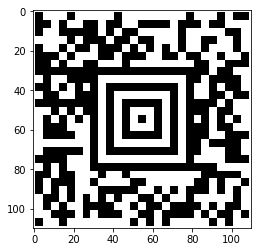

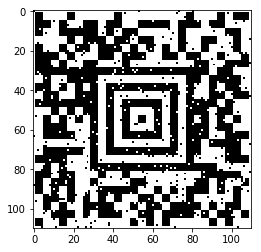

CPU times: user 671 ms, sys: 63.1 ms, total: 734 ms
Wall time: 891 ms


False

In [474]:
%%time
color_inverse("aztec1.png", "aztec", verbose=True, change_rate=.03)

In [244]:
def broken_pixels(fname: str, imtype: str, change_rate=.01, verbose=False, mode="black") -> bool:
    assert mode in ["black", "white", "mixed"]
    
    real_key = keys[int(fname.replace(imtype, "").replace(".png", "")) - 1]
    img = cv.imread(imtype + "/" + fname, cv.IMREAD_GRAYSCALE)
    
    if verbose:
        plt.imshow(img, cmap="gray")
        plt.show()
    
    _iter = int(img.shape[0] * img.shape[1] * change_rate)
    change_set = set()
    
    for _ in range(_iter):
        while 1:
            _temp = (np.random.randint(0, img.shape[0]), np.random.randint(0, img.shape[1]))
            if _temp not in change_set:
                change_set.add(_temp)
                break
    if mode=="black":
        for x, y in change_set:
            img[x][y] = 0
    elif mode=="white":
        for x, y in change_set:
            img[x][y] = 255
    elif mode=="mixed":
        for x, y in change_set:
            img[x][y] = random.choice([0, 255])
    
    if verbose:
        plt.imshow(img, cmap="gray")
        plt.show()
        
    Image.fromarray(img).save("buff.png")
    zx = BarCodeReader()
    bar = zx.decode("buff.png")
#     print(bar)
    
    if bar is None:
        return False
    
    if real_key == bar.raw:
        return True
    else:
        return False

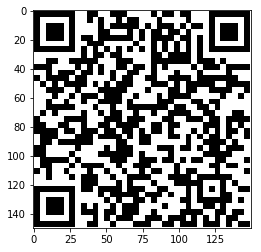

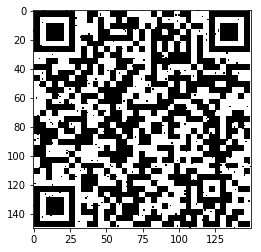

CPU times: user 784 ms, sys: 97.9 ms, total: 881 ms
Wall time: 2.67 s


True

In [675]:
%%time
broken_pixels("qr1.png", "qr", verbose=True, change_rate=.02, mode="black")

In [319]:
def gauss_noize(fname: str, imtype: str, change_rate=.01, verbose=False) -> bool:
    real_key = keys[int(fname.replace(imtype, "").replace(".png", "")) - 1]
    img = cv.imread(imtype + "/" + fname, cv.IMREAD_GRAYSCALE)
    
    if verbose:
        plt.imshow(img, cmap="gray")
        plt.show()
    
    _iter = int(img.shape[0] * img.shape[1] * change_rate)
    change_set = set()
    _rand_subs = np.random.normal(loc=np.mean(img), scale=np.std(img), size=_iter)
    
    for _ in range(_iter):
        while 1:
            _temp = (np.random.randint(0, img.shape[0]), np.random.randint(0, img.shape[1]))
            if _temp not in change_set:
                change_set.add(_temp)
                break
    
    for coords, rand in zip(change_set, _rand_subs):
        img[coords[0]][coords[1]] = rand
    
    if verbose:
        plt.imshow(img, cmap="gray")
        plt.show()
        
    Image.fromarray(img).save("buff.png")
    zx = BarCodeReader()
    bar = zx.decode("buff.png")
    
    if bar is None:
        return False
    
    if real_key == bar.raw:
        return True
    else:
        return False

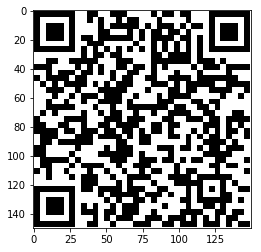

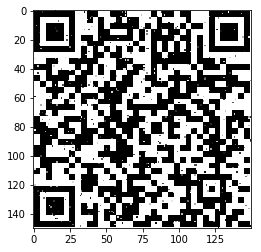

CPU times: user 722 ms, sys: 66 ms, total: 788 ms
Wall time: 943 ms


False

In [511]:
%%time
gauss_noize("qr1.png", "qr", verbose=True, change_rate=.02)

In [364]:
def line_cropping(fname: str, imtype: str, verbose=False, mode="vertical", line_width=5, color_mode="black") -> bool:
    assert mode in ["vertical", "horizontal"]
    assert color_mode in ["black", "white"]
    
    real_key = keys[int(fname.replace(imtype, "").replace(".png", "")) - 1]
    img = cv.imread(imtype + "/" + fname, cv.IMREAD_GRAYSCALE)
    
    if verbose:
        plt.imshow(img, cmap="gray")
        plt.show()
    
    _assign_color = 255 if color_mode=="white" else 0
    
    if mode == "vertical":
        _r_val = np.random.randint(0,img.shape[1] - line_width)
        img[: , _r_val:_r_val+line_width] = _assign_color
    elif mode == "horizontal":
        _r_val = np.random.randint(0,img.shape[0] - line_width)
        img[_r_val:_r_val+line_width, :] = _assign_color
    
    if verbose:
        plt.imshow(img, cmap="gray")
        plt.show()
        
    Image.fromarray(img).save("buff.png")
    zx = BarCodeReader()
    bar = zx.decode("buff.png")
    
    if bar is None:
        return False
    
    if real_key == bar.raw:
        return True
    else:
        return False

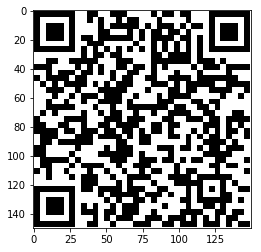

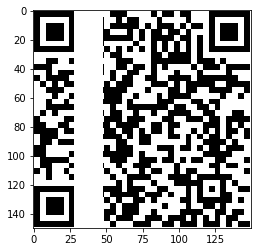

CPU times: user 697 ms, sys: 66.4 ms, total: 763 ms
Wall time: 1.07 s


True

In [521]:
%%time
line_cropping("qr1.png", "qr", verbose=True, color_mode="white", mode="vertical", line_width=20)

### 3) Blurring

In [392]:
BLUR_TYPE = {"mean":ImageFilter.BoxBlur, "median":ImageFilter.MedianFilter, "gaussian":ImageFilter.GaussianBlur}

In [388]:
def blur(fname: str, imtype: str, verbose=False, blur_type="mean", radius=1) -> bool:
    assert blur_type in BLUR_TYPE.keys()
    
    real_key = keys[int(fname.replace(imtype, "").replace(".png", "")) - 1]
    img = cv.imread(imtype + "/" + fname, cv.IMREAD_GRAYSCALE)
    pil_img = Image.fromarray(img)
    
    if verbose:
        plt.imshow(img, cmap="gray")
        plt.show()
        
    if blur_type == "median":
        pil_img = pil_img.filter(BLUR_TYPE[blur_type](size=radius))
    else:
        pil_img = pil_img.filter(BLUR_TYPE[blur_type](radius=radius))
    pil_img.save("buff.png")
    
    if verbose:
        plt.imshow(np.asarray(pil_img), cmap="gray")
        plt.show()
        
    zx = BarCodeReader()
    bar = zx.decode("buff.png")
    
    if bar is None:
        return False
    
    if real_key == bar.raw:
        return True
    else:
        return False

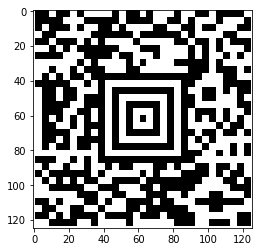

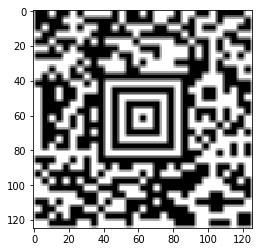

CPU times: user 701 ms, sys: 68.8 ms, total: 770 ms
Wall time: 1.3 s


False

In [734]:
%%time
blur("aztec2.png", "aztec", verbose=True, blur_type="mean", radius=1)

In [419]:
def motion_blur(fname: str, imtype: str, verbose=False, kernel_size=3, mode="vertical") -> bool:
    assert mode in ["vertical", "horizontal"]
    
    real_key = keys[int(fname.replace(imtype, "").replace(".png", "")) - 1]
    img = cv.imread(imtype + "/" + fname, cv.IMREAD_GRAYSCALE)
    
    if verbose:
        plt.imshow(img, cmap="gray")
        plt.show()
    
    if mode=="vertical":
        kernel_v = np.zeros((kernel_size, kernel_size))
        kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)
        kernel_v /= kernel_size
        mb = cv.filter2D(img, -1, kernel_v)
        
    elif mode=="horizontal":
        kernel_h = np.zeros((kernel_size, kernel_size))
        kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
        kernel_h /= kernel_size
        mb = cv.filter2D(img, -1, kernel_h)
        
    if verbose:
        plt.imshow(mb, cmap="gray")
        plt.show()
        
    Image.fromarray(mb).save("buff.png")
    
    zx = BarCodeReader()
    bar = zx.decode("buff.png")
    
    if bar is None:
        return False
    
    if real_key == bar.raw:
        return True
    else:
        return False

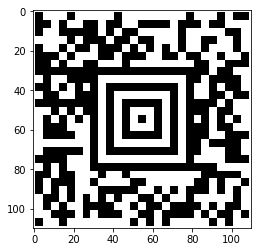

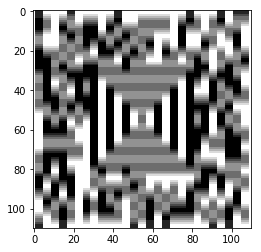

CPU times: user 771 ms, sys: 89.8 ms, total: 861 ms
Wall time: 2.36 s


False

In [680]:
%%time
motion_blur("aztec1.png", "aztec", verbose=True, mode="vertical", kernel_size=7)

### 4) Stats collection

#### 4.1) Pixel value adding

In [443]:
ch_rates = (.005, .01, .015)
aztec_positive = []
aztec_negative = []
qr_positive = []
qr_negative = []

In [444]:
np.random.seed(0)
for rate in ch_rates:
    for i in tqdm.tqdm(range(1,1001)):
        if pixel_value_adding("qr{}.png".format(i), "qr", verbose=False, change_rate=rate):
            qr_positive.append((keys[i-1], rate))
        else:
            qr_negative.append((keys[i-1], rate))
        if pixel_value_adding("aztec{}.png".format(i), "aztec", verbose=False, change_rate=rate):
            aztec_positive.append((keys[i-1], rate))
        else:
            aztec_negative.append((keys[i-1], rate))

100%|██████████| 1000/1000 [16:09<00:00,  1.03it/s]


In [607]:
res_qr = [0 for _ in ch_rates]
res_aztec = [0 for _ in ch_rates]
rates = (.005, .01, .015)
for i in aztec_positive:
    res_aztec[rates.index(i[1])] += 1
for i in qr_positive:
    res_qr[rates.index(i[1])] += 1

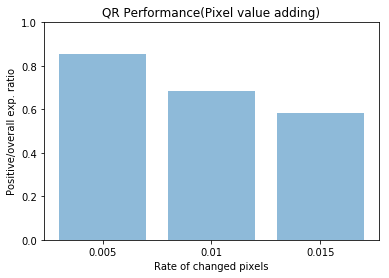

In [608]:
labels = rates
perf = [i/1000 for i in res_qr]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("Rate of changed pixels")
plt.title("QR Performance(Pixel value adding)")
plt.show()

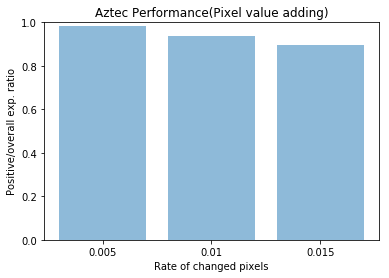

In [609]:
labels = rates
perf = [i/1000 for i in res_aztec]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("Rate of changed pixels")
plt.title("Aztec Performance(Pixel value adding)")
plt.show()

#### 4.2) Float mult

In [456]:
ch_rates = (.01, .02, .03)
aztec_positive1 = []
aztec_negative1 = []
qr_positive1 = []
qr_negative1 = []

In [457]:
np.random.seed(0)
for rate in ch_rates:
    for i in tqdm.tqdm(range(1,1001)):
        if pixel_value_float_multiplying("qr{}.png".format(i), "qr", verbose=False, change_rate=rate):
            qr_positive1.append((keys[i-1], rate))
        else:
            qr_negative1.append((keys[i-1], rate))
        if pixel_value_float_multiplying("aztec{}.png".format(i), "aztec", verbose=False, change_rate=rate):
            aztec_positive1.append((keys[i-1], rate))
        else:
            aztec_negative1.append((keys[i-1], rate))

100%|██████████| 1000/1000 [16:15<00:00,  1.02it/s]


In [458]:
len(qr_positive1)

1775

In [459]:
len(aztec_positive1)

2163

In [610]:
res_qr = [0 for _ in ch_rates]
res_aztec = [0 for _ in ch_rates]
rates = (.01, .02, .03)
for i in aztec_positive1:
    res_aztec[rates.index(i[1])] += 1
for i in qr_positive1:
    res_qr[rates.index(i[1])] += 1

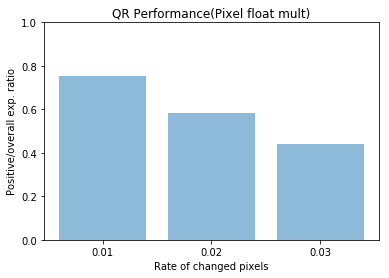

In [611]:
labels = rates
perf = [i/1000 for i in res_qr]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("Rate of changed pixels")
plt.title("QR Performance(Pixel float mult)")
plt.show()

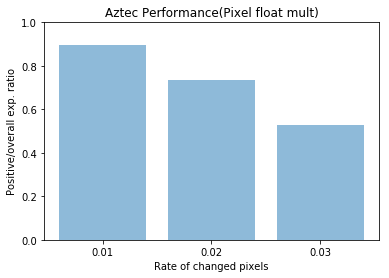

In [612]:
labels = rates
perf = [i/1000 for i in res_aztec]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("Rate of changed pixels")
plt.title("Aztec Performance(Pixel float mult)")
plt.show()

#### 4.3) Color Inverse

In [476]:
ch_rates = (.015, .02, .025)
aztec_positive2 = []
aztec_negative2 = []
qr_positive2 = []
qr_negative2 = []

In [477]:
np.random.seed(0)
for rate in ch_rates:
    for i in tqdm.tqdm(range(1,1001)):
        if color_inverse("qr{}.png".format(i), "qr", verbose=False, change_rate=rate):
            qr_positive2.append((keys[i-1], rate))
        else:
            qr_negative2.append((keys[i-1], rate))
        if color_inverse("aztec{}.png".format(i), "aztec", verbose=False, change_rate=rate):
            aztec_positive2.append((keys[i-1], rate))
        else:
            aztec_negative2.append((keys[i-1], rate))

100%|██████████| 1000/1000 [15:33<00:00,  1.07it/s]


In [478]:
len(qr_positive2)

495

In [479]:
len(aztec_positive2)

1167

In [613]:
res_qr = [0 for _ in ch_rates]
res_aztec = [0 for _ in ch_rates]
rates = (.015, .02, .025)
for i in aztec_positive2:
    res_aztec[rates.index(i[1])] += 1
for i in qr_positive2:
    res_qr[rates.index(i[1])] += 1

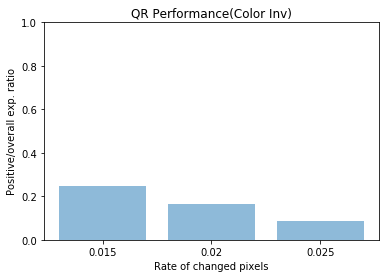

In [614]:
labels = rates
perf = [i/1000 for i in res_qr]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("Rate of changed pixels")
plt.title("QR Performance(Color Inv)")
plt.show()

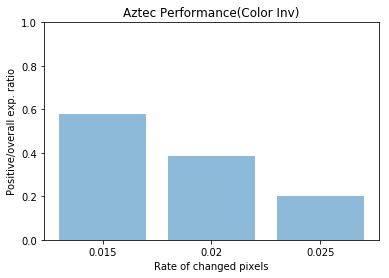

In [615]:
labels = rates
perf = [i/1000 for i in res_aztec]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("Rate of changed pixels")
plt.title("Aztec Performance(Color Inv)")
plt.show()

#### 4.4) Broken pixels in black mode

In [488]:
ch_rates = (.01, .02, .03)
aztec_positive3 = []
aztec_negative3 = []
qr_positive3 = []
qr_negative3 = []

In [489]:
np.random.seed(0)
for rate in ch_rates:
    for i in tqdm.tqdm(range(1,1001)):
        if broken_pixels("qr{}.png".format(i), "qr", verbose=False, change_rate=rate, mode="black"):
            qr_positive3.append((keys[i-1], rate))
        else:
            qr_negative3.append((keys[i-1], rate))

        if broken_pixels("aztec{}.png".format(i), "aztec", verbose=False, change_rate=rate, mode="black"):
            aztec_positive3.append((keys[i-1], rate))
        else:
            aztec_negative3.append((keys[i-1], rate))

100%|██████████| 1000/1000 [15:58<00:00,  1.04it/s]


In [490]:
len(qr_positive3)

1810

In [491]:
len(aztec_positive3)

2105

In [616]:
res_qr = [0 for _ in ch_rates]
res_aztec = [0 for _ in ch_rates]
rates = (.01, .02, .03)
for i in aztec_positive3:
    res_aztec[rates.index(i[1])] += 1
for i in qr_positive3:
    res_qr[rates.index(i[1])] += 1

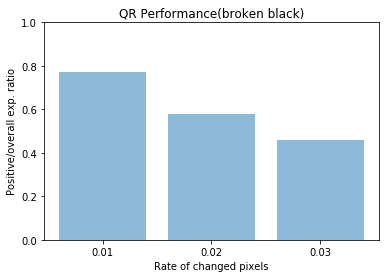

In [617]:
labels = rates
perf = [i/1000 for i in res_qr]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("Rate of changed pixels")
plt.title("QR Performance(broken black)")
plt.show()

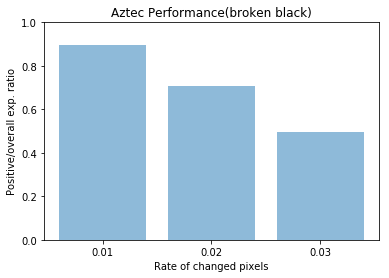

In [618]:
labels = rates
perf = [i/1000 for i in res_aztec]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("Rate of changed pixels")
plt.title("Aztec Performance(broken black)")
plt.show()

#### 4.5) Broken white

In [495]:
ch_rates = (.01, .02, .03)
aztec_positive4 = []
aztec_negative4 = []
qr_positive4 = []
qr_negative4 = []

In [496]:
np.random.seed(0)
for rate in ch_rates:
    for i in tqdm.tqdm(range(1,1001)):
        if broken_pixels("qr{}.png".format(i), "qr", verbose=False, change_rate=rate, mode="white"):
            qr_positive4.append((keys[i-1], rate))
        else:
            qr_negative4.append((keys[i-1], rate))
        if broken_pixels("aztec{}.png".format(i), "aztec", verbose=False, change_rate=rate, mode="white"):
            aztec_positive4.append((keys[i-1], rate))
        else:
            aztec_negative4.append((keys[i-1], rate))


100%|██████████| 1000/1000 [15:50<00:00,  1.05it/s]


In [583]:
len(qr_positive4)

837

In [584]:
len(aztec_positive4)

1909

In [619]:
res_qr = [0 for _ in ch_rates]
res_aztec = [0 for _ in ch_rates]
rates = (.01, .02, .03)
for i in aztec_positive4:
    res_aztec[rates.index(i[1])] += 1
for i in qr_positive4:
    res_qr[rates.index(i[1])] += 1

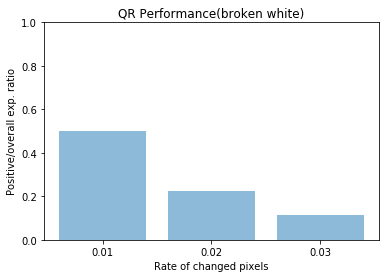

In [620]:
labels = rates
perf = [i/1000 for i in res_qr]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("Rate of changed pixels")
plt.title("QR Performance(broken white)")
plt.show()

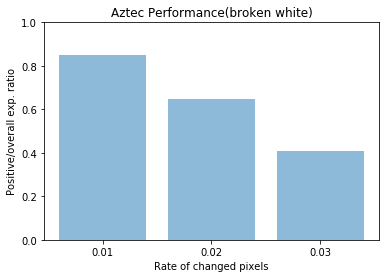

In [621]:
labels = rates
perf = [i/1000 for i in res_aztec]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("Rate of changed pixels")
plt.title("Aztec Performance(broken white)")
plt.show()

#### 4.5) Broken mixed

In [499]:
ch_rates = (.01, .02, .03)
aztec_positive5 = []
aztec_negative5 = []
qr_positive5 = []
qr_negative5 = []

In [500]:
np.random.seed(0)
for rate in ch_rates:
    for i in tqdm.tqdm(range(1,1001)):
        if broken_pixels("qr{}.png".format(i), "qr", verbose=False, change_rate=rate, mode="mixed"):
            qr_positive5.append((keys[i-1], rate))
        else:
            qr_negative5.append((keys[i-1], rate))
        if broken_pixels("aztec{}.png".format(i), "aztec", verbose=False, change_rate=rate, mode="mixed"):
            aztec_positive5.append((keys[i-1], rate))
        else:
            aztec_negative5.append((keys[i-1], rate))

100%|██████████| 1000/1000 [15:51<00:00,  1.05it/s]


In [502]:
len(qr_positive5)

1218

In [503]:
len(aztec_positive5)

2194

In [622]:
res_qr = [0 for _ in ch_rates]
res_aztec = [0 for _ in ch_rates]
rates = (.01, .02, .03)
for i in aztec_positive5:
    res_aztec[rates.index(i[1])] += 1
for i in qr_positive5:
    res_qr[rates.index(i[1])] += 1

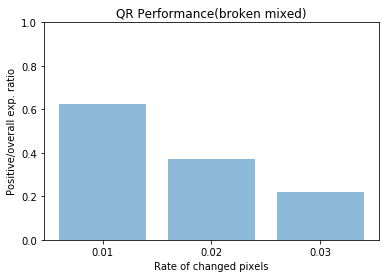

In [623]:
labels = rates
perf = [i/1000 for i in res_qr]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("Rate of changed pixels")
plt.title("QR Performance(broken mixed)")
plt.show()

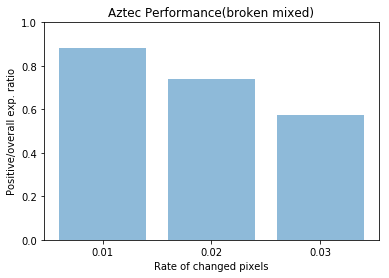

In [624]:
labels = rates
perf = [i/1000 for i in res_aztec]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("Rate of changed pixels")
plt.title("Aztec Performance(broken mixed)")
plt.show()

#### 4.6) gauss noize

In [512]:
ch_rates = (.01, .015, .02)
aztec_positive6 = []
aztec_negative6 = []
qr_positive6 = []
qr_negative6 = []

In [513]:
np.random.seed(0)
for rate in ch_rates:
    for i in tqdm.tqdm(range(1,1001)):
        if gauss_noize("qr{}.png".format(i), "qr", verbose=False, change_rate=rate):
            qr_positive6.append((keys[i-1], rate))
        else:
            qr_negative6.append((keys[i-1], rate))
        if gauss_noize("aztec{}.png".format(i), "aztec", verbose=False, change_rate=rate):
            aztec_positive6.append((keys[i-1], rate))
        else:
            aztec_negative6.append((keys[i-1], rate))

100%|██████████| 1000/1000 [16:02<00:00,  1.04it/s]


In [514]:
len(qr_positive6)

1468

In [515]:
len(aztec_positive6)

2477

In [625]:
res_qr = [0 for _ in ch_rates]
res_aztec = [0 for _ in ch_rates]
rates = (.01, .015, .02)
for i in aztec_positive6:
    res_aztec[rates.index(i[1])] += 1
for i in qr_positive6:
    res_qr[rates.index(i[1])] += 1

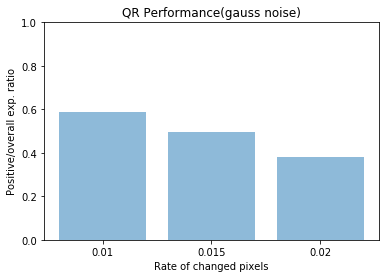

In [626]:
labels = rates
perf = [i/1000 for i in res_qr]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("Rate of changed pixels")
plt.title("QR Performance(gauss noise)")
plt.show()

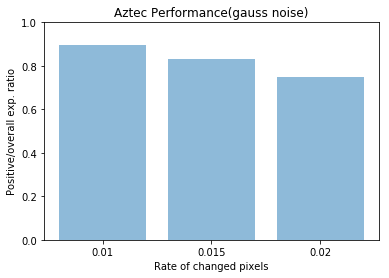

In [627]:
labels = rates
perf = [i/1000 for i in res_aztec]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("Rate of changed pixels")
plt.title("Aztec Performance(gauss noise)")
plt.show()

#### 4.7) line cropping vertical

In [524]:
ch_rates = (10, 15, 20)
aztec_positive7 = []
aztec_negative7 = []
qr_positive7 = []
qr_negative7 = []

In [525]:
np.random.seed(0)
for rate in ch_rates:
    for i in tqdm.tqdm(range(1,1001)):
        if line_cropping("qr{}.png".format(i), "qr", verbose=False, color_mode="white", mode="vertical", line_width=rate):
            qr_positive7.append((keys[i-1], rate))
        else:
            qr_negative7.append((keys[i-1], rate))
        if line_cropping("aztec{}.png".format(i), "aztec", verbose=False, color_mode="white", mode="vertical", line_width=rate):
            aztec_positive7.append((keys[i-1], rate))
        else:
            aztec_negative7.append((keys[i-1], rate))

100%|██████████| 1000/1000 [15:58<00:00,  1.04it/s]


In [526]:
len(qr_positive7)

1715

In [527]:
len(aztec_positive7)

388

In [628]:
res_qr = [0 for _ in ch_rates]
res_aztec = [0 for _ in ch_rates]
rates = (10, 15, 20)
for i in aztec_positive7:
    res_aztec[rates.index(i[1])] += 1
for i in qr_positive7:
    res_qr[rates.index(i[1])] += 1

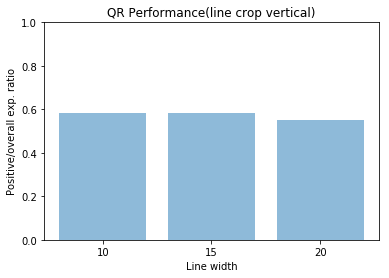

In [629]:
labels = rates
perf = [i/1000 for i in res_qr]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("Line width")
plt.title("QR Performance(line crop vertical)")
plt.show()

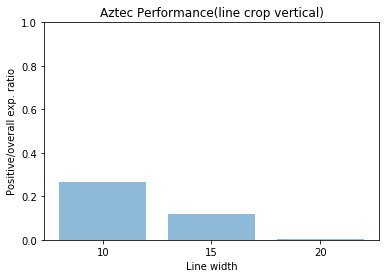

In [635]:
labels = rates
perf = [i/1000 for i in res_aztec]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("Line width")
plt.title("Aztec Performance(line crop vertical)")
plt.show()

#### 4.7) line cropping horizontal

In [528]:
ch_rates = (10, 15, 20)
aztec_positive8 = []
aztec_negative8 = []
qr_positive8 = []
qr_negative8 = []

In [529]:
np.random.seed(0)
for rate in ch_rates:
    for i in tqdm.tqdm(range(1,1001)):
        if line_cropping("qr{}.png".format(i), "qr", verbose=False, color_mode="white", mode="horizontal", line_width=rate):
            qr_positive8.append((keys[i-1], rate))
        else:
            qr_negative8.append((keys[i-1], rate))
        if line_cropping("aztec{}.png".format(i), "aztec", verbose=False, color_mode="white", mode="horizontal", line_width=rate):
            aztec_positive8.append((keys[i-1], rate))
        else:
            aztec_negative8.append((keys[i-1], rate))

100%|██████████| 1000/1000 [15:31<00:00,  1.07it/s]


In [530]:
len(qr_positive8)

1361

In [531]:
len(aztec_positive8)

423

In [636]:
res_qr = [0 for _ in ch_rates]
res_aztec = [0 for _ in ch_rates]
rates = (10, 15, 20)
for i in aztec_positive8:
    res_aztec[rates.index(i[1])] += 1
for i in qr_positive8:
    res_qr[rates.index(i[1])] += 1

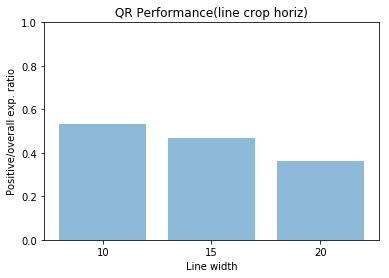

In [637]:
labels = rates
perf = [i/1000 for i in res_qr]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("Line width")
plt.title("QR Performance(line crop horiz)")
plt.show()

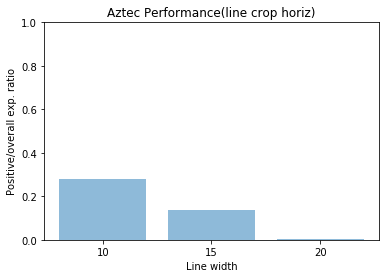

In [638]:
labels = rates
perf = [i/1000 for i in res_aztec]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("Line width")
plt.title("Aztec Performance(line crop horiz)")
plt.show()

### 5) Blurring

#### 5.1) Motion blur vert

In [661]:
ch_rates = (5, 6, 7)
aztec_positive9 = []
aztec_negative9 = []
qr_positive9 = []
qr_negative9 = []

In [663]:
np.random.seed(0)
for rate in ch_rates:
    for i in tqdm.tqdm(range(1,1001)):
        if motion_blur("qr{}.png".format(i), "qr", verbose=False, mode="vertical", kernel_size=rate):
            qr_positive9.append((keys[i-1], rate))
        else:
            qr_negative9.append((keys[i-1], rate))
        if motion_blur("aztec{}.png".format(i), "aztec", verbose=False, mode="vertical", kernel_size=rate):
            aztec_positive9.append((keys[i-1], rate))
        else:
            aztec_negative9.append((keys[i-1], rate))

100%|██████████| 1000/1000 [16:20<00:00,  1.02it/s]


In [670]:
len(aztec_positive9)

1647

In [666]:
res_qr = [0 for _ in ch_rates]
res_aztec = [0 for _ in ch_rates]
rates = (5, 6, 7)
for i in aztec_positive9:
    res_aztec[rates.index(i[1])] += 1
for i in qr_positive9:
    res_qr[rates.index(i[1])] += 1

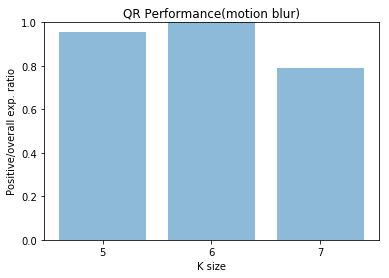

In [668]:
labels = rates
perf = [i/1000 for i in res_qr]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("K size")
plt.title("QR Performance(motion blur)")
plt.show()

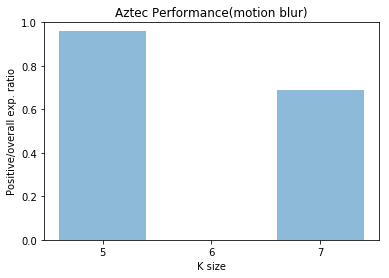

In [669]:
labels = rates
perf = [i/1000 for i in res_aztec]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("K size")
plt.title("Aztec Performance(motion blur)")
plt.show()

#### 5.2) Median blur

In [706]:
ch_rates = (3, 5)
aztec_positive10 = []
aztec_negative10 = []
qr_positive10 = []
qr_negative10 = []

In [707]:
np.random.seed(0)
for rate in ch_rates:
    for i in tqdm.tqdm(range(1,1001)):
        if blur("qr{}.png".format(i), "qr", verbose=False, radius=rate, blur_type="median"):
            qr_positive10.append((keys[i-1], rate))
        else:
            qr_negative10.append((keys[i-1], rate))
        if blur("aztec{}.png".format(i), "aztec", verbose=False, radius=rate, blur_type="median"):
            aztec_positive10.append((keys[i-1], rate))
        else:
            aztec_negative10.append((keys[i-1], rate))

100%|██████████| 1000/1000 [15:36<00:00,  1.07it/s]


In [709]:
res_qr = [0 for _ in ch_rates]
res_aztec = [0 for _ in ch_rates]
rates = (3, 5)
for i in aztec_positive10:
    res_aztec[rates.index(i[1])] += 1
for i in qr_positive10:
    res_qr[rates.index(i[1])] += 1

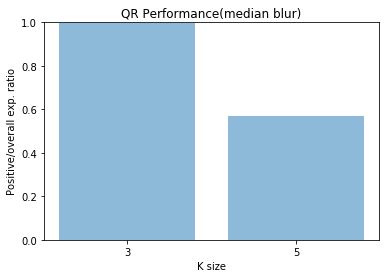

In [711]:
labels = rates
perf = [i/1000 for i in res_qr]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("K size")
plt.title("QR Performance(median blur)")
plt.show()

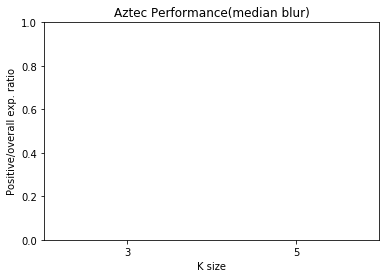

In [712]:
labels = rates
perf = [i/1000 for i in res_aztec]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("K size")
plt.title("Aztec Performance(median blur)")
plt.show()

#### 5.3) BoxBlur

In [726]:
ch_rates = (1, 2)
aztec_positive11 = []
aztec_negative11 = []
qr_positive11 = []
qr_negative11 = []

In [727]:
np.random.seed(0)
for rate in ch_rates:
    for i in tqdm.tqdm(range(1,1001)):
        if blur("qr{}.png".format(i), "qr", verbose=False, radius=rate, blur_type="mean"):
            qr_positive11.append((keys[i-1], rate))
        else:
            qr_negative11.append((keys[i-1], rate))
        if blur("aztec{}.png".format(i), "aztec", verbose=False, radius=rate, blur_type="mean"):
            aztec_positive11.append((keys[i-1], rate))
        else:
            aztec_negative11.append((keys[i-1], rate))

100%|██████████| 1000/1000 [15:49<00:00,  1.05it/s]


In [730]:
res_qr = [0 for _ in ch_rates]
res_aztec = [0 for _ in ch_rates]
rates = (1, 2)
for i in aztec_positive11:
    res_aztec[rates.index(i[1])] += 1
for i in qr_positive11:
    res_qr[rates.index(i[1])] += 1

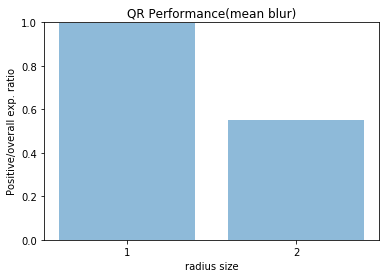

In [731]:
labels = rates
perf = [i/1000 for i in res_qr]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("radius size")
plt.title("QR Performance(mean blur)")
plt.show()

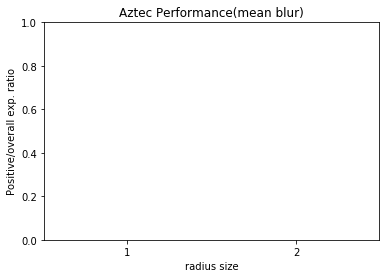

In [732]:
labels = rates
perf = [i/1000 for i in res_aztec]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("radius size")
plt.title("Aztec Performance(mean blur)")
plt.show()

#### 5.4) MB horiz

In [735]:
ch_rates = (5, 6, 7)
aztec_positive12 = []
aztec_negative12 = []
qr_positive12 = []
qr_negative12 = []

In [736]:
np.random.seed(0)
for rate in ch_rates:
    for i in tqdm.tqdm(range(1,1001)):
        if motion_blur("qr{}.png".format(i), "qr", verbose=False, mode="horizontal", kernel_size=rate):
            qr_positive12.append((keys[i-1], rate))
        else:
            qr_negative12.append((keys[i-1], rate))
        if motion_blur("aztec{}.png".format(i), "aztec", verbose=False, mode="horizontal", kernel_size=rate):
            aztec_positive12.append((keys[i-1], rate))
        else:
            aztec_negative12.append((keys[i-1], rate))

100%|██████████| 1000/1000 [15:52<00:00,  1.05it/s]


In [737]:
res_qr = [0 for _ in ch_rates]
res_aztec = [0 for _ in ch_rates]
rates = (5, 6, 7)
for i in aztec_positive12:
    res_aztec[rates.index(i[1])] += 1
for i in qr_positive12:
    res_qr[rates.index(i[1])] += 1

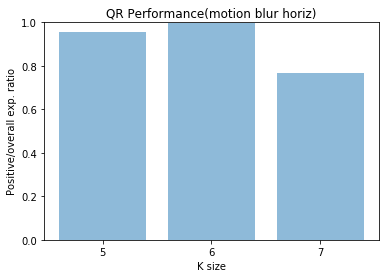

In [738]:
labels = rates
perf = [i/1000 for i in res_qr]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("K size")
plt.title("QR Performance(motion blur horiz)")
plt.show()

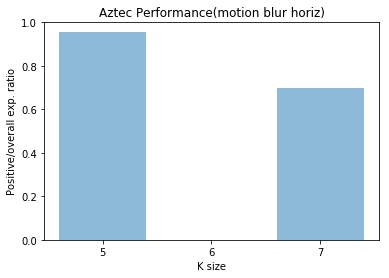

In [739]:
labels = rates
perf = [i/1000 for i in res_aztec]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("K size")
plt.title("Aztec Performance(motion blur horiz)")
plt.show()

### 6) Xor

In [740]:
ch_rates = (.01, .015, .02)
aztec_positive13 = []
aztec_negative13 = []
qr_positive13 = []
qr_negative13 = []

In [741]:
np.random.seed(0)
for rate in ch_rates:
    for i in tqdm.tqdm(range(1,1001)):
        if pixel_value_xor("qr{}.png".format(i), "qr", verbose=False, change_rate=rate):
            qr_positive13.append((keys[i-1], rate))
        else:
            qr_negative13.append((keys[i-1], rate))
        if pixel_value_xor("aztec{}.png".format(i), "aztec", verbose=False, change_rate=rate):
            aztec_positive13.append((keys[i-1], rate))
        else:
            aztec_negative13.append((keys[i-1], rate))

100%|██████████| 1000/1000 [15:52<00:00,  1.05it/s]


In [742]:
res_qr = [0 for _ in ch_rates]
res_aztec = [0 for _ in ch_rates]
rates = (.01, .015, .02)
for i in aztec_positive13:
    res_aztec[rates.index(i[1])] += 1
for i in qr_positive13:
    res_qr[rates.index(i[1])] += 1

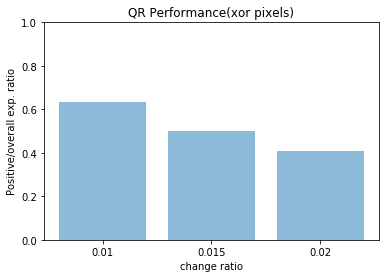

In [743]:
labels = rates
perf = [i/1000 for i in res_qr]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("change ratio")
plt.title("QR Performance(xor pixels)")
plt.show()

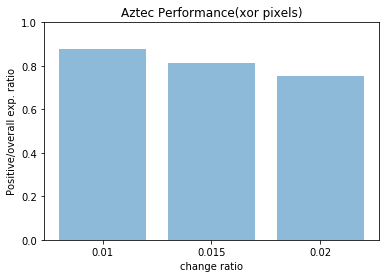

In [744]:
labels = rates
perf = [i/1000 for i in res_aztec]
y_pos = np.arange(len(labels))
plt.ylim(0, 1)
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel("Positive/overall exp. ratio")
plt.xlabel("change ratio")
plt.title("Aztec Performance(xor pixels)")
plt.show()